# 6. 反応速度式の関数でODEを解く方法

通常、`ReactionRule`は高々二つの分子が反応する質量作用式（Mass Action Kinetics）を表現するために使われます。より複雑な化学反応式を扱う場合には、`ReactionRule`を`ReactionRuleDescriptor`によって拡張することができます。ここでは、`ReactionRuleDescriptor`を利用した`ode`特有の計算について説明します。

In [1]:
%matplotlib inline
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

## 6.1. ReactionRuleDescriptor

`ReactionRule`は基質、生成物、そして反応速度定数から構成されます。

In [2]:
rr1 = ReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
rr1.set_k(1.0)
print(len(rr1.reactants()))  # => 2
print(len(rr1.products()))  # => 1
print(rr1.k())  # => 1.0
print(rr1.as_string())  # => A+B>C|1
print(rr1.has_descriptor())  # => False

2
1
1.0
A+B>C|1
False


これに加えて、`ReactionRule`は`ReactionRuleDescriptor`によって拡張することができます。

In [3]:
desc1 = ReactionRuleDescriptorMassAction(1.0)
print(desc1.k())
rr1.set_descriptor(desc1)

1.0


関連付けた`ReactionRuleDescriptor`は`ReactionRule`から取得することができます。

In [4]:
print(rr1.has_descriptor())
print(rr1.get_descriptor())
print(rr1.get_descriptor().k())

True
1.0


`ReactionRuleDescriptor`は基質、生成物の量論係数を保有します。

In [5]:
desc1.set_reactant_coefficient(0, 2)  # Set a coefficient of the first reactant
desc1.set_reactant_coefficient(1, 3)  # Set a coefficient of the second reactant
desc1.set_product_coefficient(0, 4)  # Set a coefficient of the first product
print(rr1.as_string())

2*A+3*B>4*C|1


設定された量論係数のリストは以下の方法で取得できます：

In [6]:
print(desc1.reactant_coefficients())  # => [2.0, 3.0]
print(desc1.product_coefficients())  # => [4.0]

[2.0, 3.0]
[4.0]


現在、`ReactionRuleDescriptor`は`ode`でしか正しく動くことが保証されていないことに注意してください。

## 6.2. ReactionRuleDescriptorPyFunc

`ReactionRuleDescriptor`は、各`Species`の量から反応速度を計算するための関数も提供します。この章では、ユーザー独自の化学反応速度式を記述する方法について説明します。

In [7]:
rr1 = ReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
print(rr1.as_string())

A+B>C|0


まず、化学反応速度式を表すPython関数を定義します。この関数は6つの引数を受け取り、1つの実数値を返さなくてはいけません。最初と二番目の引数は、それぞれ基質と生成物の値のリストになります。三番目と四番目の引数には、容積と時刻が与えられます。また、基質と生成物の化学量論係数のリストが最後の二つの引数として与えられます。

In [8]:
def ratelaw(r, p, v, t, rc, pc):
    return 1.0 * r[0] * r[1] - 2.0 * p[0]

`ReactionRuleDescriptorPyFunc`はこうして定義されたPython関数を受け取ります。

In [9]:
desc1 = ReactionRuleDescriptorPyfunc(ratelaw, 'test')
desc1.set_reactant_coefficients([1, 1])
desc1.set_product_coefficients([1])
rr1.set_descriptor(desc1)
print(desc1.as_string())
print(rr1.as_string())

test
1*A+1*B>1*C|0


`lambda`式で定義された関数でも構いません。

In [10]:
desc2 = ReactionRuleDescriptorPyfunc(lambda r, p, v, t, rc, pc:  1.0 * r[0] * r[1] - 2.0 * p[0], 'test')
desc2.set_reactant_coefficients([1, 1])
desc2.set_product_coefficients([1])
rr1.set_descriptor(desc2)
print(desc1.as_string())
print(rr1.as_string())

test
1*A+1*B>1*C|0


では、この関数が正しく動くかテストするために`ode.World`を使って式を評価してみます。

In [11]:
w = ode.World()
w.set_value(Species("A"), 10)
w.set_value(Species("B"), 20)
w.set_value(Species("C"), 30)

print(w.evaluate(rr1))  # => 140 = 1 * 10 * 20 - 2 * 30

140.0


## 6.3. NetworkModel

`NetworkModel`は`ReactionRuleDescriptor`に関連付けられた`ReactionRule`も登録することができます。

In [12]:
m1 = NetworkModel()
rr1 = create_unbinding_reaction_rule(Species("C"), Species("A"), Species("B"), 3.0)
m1.add_reaction_rule(rr1)
rr2 = create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 0.0)
desc1 = ReactionRuleDescriptorPyfunc(lambda r, p, v, t, rc, pc: 0.1 * r[0] * r[1], "test")
desc1.set_reactant_coefficients([1, 1])
desc1.set_product_coefficients([1])
rr2.set_descriptor(desc1)
m1.add_reaction_rule(rr2)

こうして登録された`ReactionRule`は、`NetworkModel`の`reaction_rules`関数を使ってリストとして得ることができます。

In [13]:
print([rr.as_string() for rr in m1.reaction_rules()])

['C>A+B|3', '1*A+1*B>1*C|0']


また、このモデルは他の場合と同様に以下のようにしてシミュレーションを実行できます：

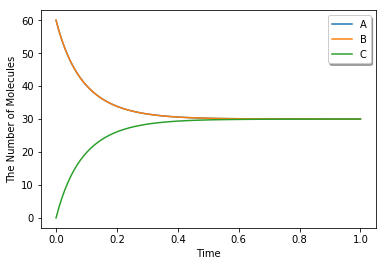

In [14]:
run_simulation(1.0, model=m1, y0={'A': 60, 'B': 60})

Pythonデコレータを使ったモデリングでは、反応速度定数として数値を与える代わりにPython関数を与えることができます。単に数値を与えた場合は、いつも通り反応速度定数と見なされ、質量作用式として機能します。

In [15]:
from functools import reduce
from operator import mul

with reaction_rules():
    A + B == C | (lambda r, *args: 0.1 * reduce(mul, r), 3.0)

m1 = get_model()

より簡潔に、式を与える代わりに`Species`の名前を用いて直接式を記述することもできます：

In [16]:
with reaction_rules():
    A + B == C | (0.1 * A * B, 3.0)

m1 = get_model()

ここで、速度式の中で左の反応式に含まれない`Species`を利用した場合、酵素として自動的に反応式に追加されます。

In [17]:
with reaction_rules():
    S > P | 1.0 * E * S / (30.0 + S)

m1 = get_model()
print(m1.reaction_rules()[0].as_string())
print(m1.reaction_rules()[0].get_descriptor().as_string())

1*S+1*E>1*P+1*E|0
((1.0*E*S)/(30.0+S))


上の例では、式に現れる分子種`E`が基質と生成物の双方に追加されていることがわかります。

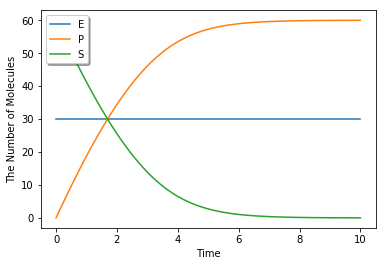

In [18]:
run_simulation(10.0, model=m1, y0={'S': 60, 'E': 30})

ここで速度式中の`Species`名の誤りに注意してください。誤りがあった場合、それはエラーではなく、意図せず誤った名前の酵素が新たに追加されることになります。

In [19]:
with reaction_rules():
    A13P2G > A23P2G | 1500 * A13B2G  # typo: A13P2G -> A13B2G

m1 = get_model()
print(m1.reaction_rules()[0].as_string())

1*A13P2G+1*A13B2G>1*A23P2G+1*A13B2G|0


こうした酵素の自動的な宣言を避けたい場合には、`util.decorator.ENABLE_IMPLICIT_DECLARATION`を`False`に設定してください。その場合、反応式に含まれない分子種が速度式に現れた時、エラーとなります:

In [20]:
util.decorator.ENABLE_IMPLICIT_DECLARATION = False

try:
    with reaction_rules():
        A13P2G > A23P2G | 1500 * A13B2G
except RuntimeError as e:
    print(repr(e))

util.decorator.ENABLE_IMPLICIT_DECLARATION = True

RuntimeError('[A13B2G] is unknown [(1500*{0})].',)


E-Cell4は生化学反応ネットワークのシミュレーションに特化して設計されているが、通常の常微分方程式を解くために利用することもできる。例えば、ロトカ・ヴォルテラの方程式は：

$$\frac{dx}{dt} = Ax - Bxy\\\frac{dy}{dt} = -Cx + Dxy$$

で与えられ、パラメータを$A=1.5, B=1, C=3, D=1, x(0)=10, y(0)=5$とした場合、以下のようにして解くことができる。

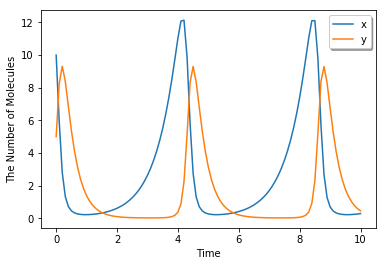

In [21]:
with reaction_rules():
    A, B, C, D = 1.5, 1, 3, 1

    ~x > x | A * x - B * x * y
    ~y > y | -C * y + D * x * y

run_simulation(10, model=get_model(), y0={'x': 10, 'y': 5})

## 6.4. ReactionRuleDescriptorにおける値と参照

ここでは反応速度式の記述に関する技術的な詳細について補足する。

まず、`Species`名を用いた速度式の記述では限られた特殊関数のみを利用できる（`exp`, `log`, `sin`, `cos`, `tan`, `asin`, `acos`, `atan`, `pi`）。たとえ、定義ブロックの外側で特殊関数を宣言（もしくはimport）していたとしても、利用できない。

In [22]:
try:
    from math import erf

    with reaction_rules():
        S > P | erf(S / 30.0)
except TypeError as e:
    print(repr(e))

TypeError('must be real number, not DivExp',)


上のエラーはPython関数である`erf`を数値ではなく、`S / 30.0`というオブジェクトに対して評価しようとした結果起きる。一方、以下の場合は問題がない：

In [23]:
from math import erf

with reaction_rules():
    S > P | erf(2.0) * S

m1 = get_model()
print(m1.reaction_rules()[0].get_descriptor().as_string())

(0.9953222650189527*S)


ここでは`erf(2.0)`を評価した結果、すなわち数値である`0.995322265019`が速度式にわたっている。従って、上の速度式は`erf`に関する参照を持たない。同様に外側であらかじめ評価された変数も利用できるが、この場合も変数に対する参照ではなく、その値のみが使われる。

In [24]:
kcat, Km = 1.0, 30.0

with reaction_rules():
    S > P | kcat * E * S / (Km + S)

m1 = get_model()
print(m1.reaction_rules()[0].get_descriptor().as_string())
kcat = 2.0  # This doesn't affect the model
print(m1.reaction_rules()[0].get_descriptor().as_string())

((1.0*E*S)/(30.0+S))
((1.0*E*S)/(30.0+S))


上の例では、たとえ変数の値を変更しても、その変更はモデル中の反応速度式に影響を与え**ない**。

他方、自分自身でPython関数を定義した場合、それは外側で宣言された他の変数への参照を有する。

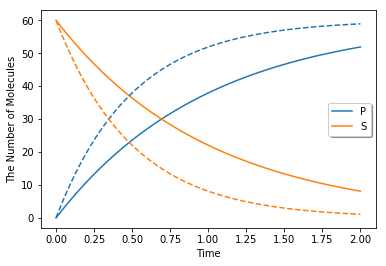

In [25]:
k1 = 1.0

with reaction_rules():
    S > P | (lambda r, *args: k1 * r[0])  # referring k1

m1 = get_model()

obs1 = run_simulation(2, model=m1, y0={"S": 60}, return_type='observer')
k1 = 2.0  # This could change the result
obs2 = run_simulation(2, model=m1, y0={"S": 60}, return_type='observer')

viz.plot_number_observer(obs1, '-', obs2, '--')

しかしながら、上のような場合は参照を利用するのではなく、異なるパラメータの値ごとに新たにモデルを生成したほうが良いだろう。

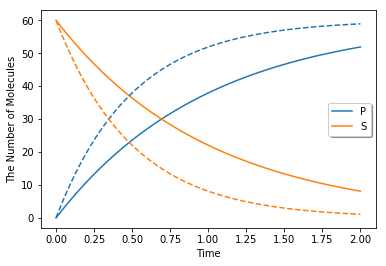

In [26]:
def create_model(k):
    with reaction_rules():
        S > P | k

    return get_model()

obs1 = run_simulation(2, model=create_model(k=1.0), y0={"S": 60}, return_type='observer')
obs2 = run_simulation(2, model=create_model(k=2.0), y0={"S": 60}, return_type='observer')
viz.plot_number_observer(obs1, '-', obs2, '--')

## 6.5. odeについてもう少し

`ode.World`において各`Species`の値は実数値として扱われる。しかしながら、他の手法との互換性のため、共通したメンバー関数`num_molecules`や`add_molecules`では値を整数値として扱う。

In [27]:
w = ode.World()
w.add_molecules(Species("A"), 2.5)
print(w.num_molecules(Species("A")))

2


特別に実数値として扱う場合には、`set_value`や`get_value`が利用できる。

In [28]:
w.set_value(Species("B"), 2.5)
print(w.get_value(Species("A")))
print(w.get_value(Species("B")))

2.0
2.5


デフォルトで`ode.Simulator`は常微分方程式の数値解法としてローゼンブロック法（`ROSENBROCK4_CONTROLLER`）を利用する。これに加えて別の二つの解法も利用することができる（`EULER`、`RUNGE_KUTTA_CASH_KARP54`）。`ROSENBROCK4_CONTROLLER`と`RUNGE_KUTTA_CASH_KARP54`は誤差制御を自動的に行うため、時間発展の最中に動的に時間幅を適応させる。他方、オイラー法（`EULER`）は固定時間幅である。

In [29]:
with reaction_rules():
    A > ~A | 1.0

m1 = get_model()

w1 = ode.World()
w1.set_value(Species("A"), 1.0)
sim1 = ode.Simulator(w1, m1, ode.EULER)
sim1.set_dt(0.01) # This is only effective for EULER
sim1.run(3.0, obs1)

`ode.Factory`でも解法や時間幅を受け取ることができる。

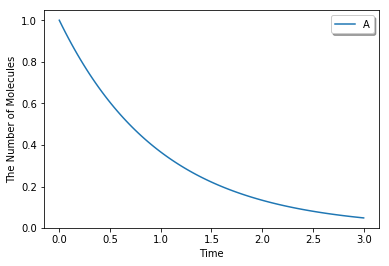

In [30]:
run_simulation(3.0, model=m1, y0={"A": 1.0}, solver=('ode', ode.EULER, 0.01))

常微分方程式を用いた例として、下記も参考にしてください。

* [Glycolysis of Human Erythrocytes](examples/example5.ipynb)
* [Drosophila Circadian Clock](../examples/example2.ipynb)
* [Attractors](../examples/example1.ipynb)